In [1]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
import random

# Data

In [2]:
# read data and split by each line
words = open('names.txt', 'r').read().splitlines()

In [3]:
len(words)

32033

In [4]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

#### Vocab of char to int mapping and int to char

In [5]:
# get all the unique chars in the dataset
chars = sorted(list(set(''.join(words))))  # set removes duplicate chars and keep unique
# map each char to a int
ctoi = {c: i+1 for i, c in enumerate(chars)}
# add a special char, for constructing bigrams of the first and last character in a word
ctoi['.'] = 0

# int to char
itoc = {i: c for c, i in ctoi.items()}

print(itoc)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# build dataset
input_size = 3  # context length, i.e. how many input chars to take to predict the next one, 3 according to Bengio et al.
def build_dataset(words):
    X, Y = [], []

    for word in words:
        input = [0] * input_size  # pad the full input with '.' to predict the first char
        
        # iterate through the chars in the word, to add to X and Y, add the last special '.' char to predict end word
        for char in word + '.':
            # add the current input, i.e. the 3 chars, to X
            X.append(input)

            # add the next char as Y
            ix = ctoi[char]
            Y.append(ix)

            # shift the input right by one char
            input = input[1:] + [ix]

    # convert to tensor
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y

random.seed(42)

# shuffle the whole dataset
random.shuffle(words)

split1_idx = int(0.8 * len(words))
split2_idx = int(0.9 * len(words))

# create train, val, test set
X_train, Y_train = build_dataset(words[:split1_idx])        # training set is for training the model parameters, i.e. weights and bias etc
X_val, Y_val = build_dataset(words[split1_idx:split2_idx])  # validation set is for finding the hyperparameters, i.e. lr etc, and also validate no overfitting
X_test, Y_test = build_dataset(words[split2_idx:])          # test set for evaluating the model on unseen data


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Model

#### Embedding

In [7]:
generator = torch.Generator().manual_seed(42)
num_emb = 10

# embed the 27 chars into 10D embedding, note Bengio et al. is 17000 words to 30
lookup = torch.randn((27, num_emb), generator=generator)  # the look up table from 27 chars to 10D

#### Hidden layer

In [8]:
num_hidden = 200

# random init weights, note no need bias at this layer because batch norm layer follows, and just use batch norm bias
W1 = torch.randn((num_emb * input_size, num_hidden), generator=generator)

#### Output layer

In [9]:
num_output = 27  # 27 chars

# init weights and bias
W2 = torch.randn((num_hidden, num_output), generator=generator)
b2 = torch.randn(num_output, generator=generator)

# batch normalization parameters, init gain to 1 and bias to 0, so that batch norm inits with unit gaussian (and gets scaled and shifted as trained)
bn_gain = torch.ones((1, num_hidden))
bn_bias = torch.zeros((1, num_hidden))

# mean and std to calculate batch norm, for the total train set, i.e. batch = full training set, unit gaussian so mean = 0, std = 1
bn_mean_total = torch.zeros((1, num_hidden))
bn_std_total = torch.ones((1, num_hidden))

parameters = [lookup, W1, W2, b2, bn_gain, bn_bias]
for p in parameters:
    p.requires_grad = True  # need to manually set grad to true, because PyTorch init these to false on leaf tensors

#### Train

In [10]:
MAX_EPOCH = 200000
log_epoch = 10000
batch_size = 32
# reasoning of minibatch:
# it's better to run more training steps with approximate gradient (minibatch)
# vs running fewer steps with exact gradient (full dataset)

epochs = []
losses = []

for epoch in range(MAX_EPOCH):
    # create minibatch training data for this pass
    batch_idx = torch.randint(0, X_train.shape[0], (batch_size,))

    # embed inputs
    emb = lookup[X_train[batch_idx]]

    # hidden layer neuron output, i.e. WX + b, where X is the output of embedding (reshaping embedding for input)
    hidden_out = emb.view(-1, num_emb * input_size) @ W1

    # batch normalization (across the batch samples), so that ouput is normally distributed (before activation function), since this prevents vanishing and exploding gradients
    bn_mean_epoch = hidden_out.mean(dim=0, keepdim=True)
    bn_std_epoch = hidden_out.std(dim=0, keepdim=True)
    hidden_norm = bn_gain * (hidden_out - bn_mean_epoch) / bn_std_epoch + bn_bias

    # calculate the running bn mean and std as the data trains
    with torch.no_grad():
        bn_mean_total = 0.999 * bn_mean_total + 0.001 * bn_mean_epoch
        bn_std_total = 0.999 * bn_std_total + 0.001 * bn_std_epoch

    # tanh activation
    hidden = torch.tanh(hidden_norm)
    # output layer neuron output logits
    logits = hidden @ W2 + b2

    # cross entropy loss, which is just softmax(logits) to get probability, then average negative log likelihood of the probability
    loss = F.cross_entropy(logits, Y_train[batch_idx])

    # reset gradients
    for p in parameters:
        p.grad = None
    
    loss.backward()  # backprop to calculate gradients

    # lr decay
    lr = 0.1 if epoch < 0.5 * MAX_EPOCH else 0.01

    # update params
    for p in parameters:
        p.data += -lr * p.grad

    # stats
    epochs.append(epoch)
    losses.append(loss.item())
    if epoch % log_epoch == 0:
        print(f'{epoch:7d}/{MAX_EPOCH:7d}: {loss.item():.4f}')

loss

      0/ 200000: 22.0277
  10000/ 200000: 2.8827
  20000/ 200000: 2.1919
  30000/ 200000: 2.3755
  40000/ 200000: 2.4962
  50000/ 200000: 2.1934
  60000/ 200000: 2.7461
  70000/ 200000: 3.1319
  80000/ 200000: 2.4625
  90000/ 200000: 2.1207
 100000/ 200000: 2.2976
 110000/ 200000: 1.7111
 120000/ 200000: 1.9515
 130000/ 200000: 2.4266
 140000/ 200000: 2.2742
 150000/ 200000: 1.8444
 160000/ 200000: 2.2548
 170000/ 200000: 2.2890
 180000/ 200000: 2.5596
 190000/ 200000: 2.7489


tensor(2.3187, grad_fn=<NllLossBackward0>)

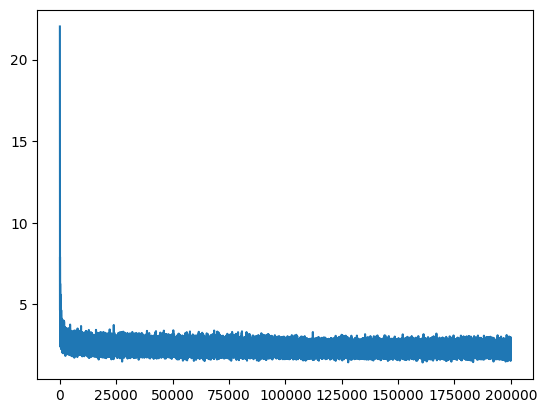

In [11]:
# plot the loss over epochs
plt.plot(epochs, losses)

In [12]:
# evaluate on validation set
with torch.no_grad():
    emb = lookup[X_val]
    hidden_out = emb.view(-1, num_emb * input_size) @ W1
    hidden_norm = bn_gain * (hidden_out - bn_mean_total) / bn_std_total + bn_bias
    hidden = torch.tanh(hidden_norm)
    logits = hidden @ W2 + b2
    val_loss = F.cross_entropy(logits, Y_val)

val_loss

tensor(2.2089)

In [13]:
# create words from the trained model

# sample 10 words
for i in range(10):
    created_word = []

    # init input with all '.' to predict the first char
    input = [0] * input_size

    # sample and create one word
    while True:
        # embed input
        emb = lookup[torch.tensor([input])]

        # forward pass
        hidden_out = emb.view(1, -1) @ W1
        hidden_norm = bn_gain * (hidden_out - bn_mean_total) / bn_std_total + bn_bias
        hidden = torch.tanh(hidden_norm)
        logits = hidden @ W2 + b2

        # softmax logits to get probabilities
        proba = F.softmax(logits, dim=1)

        # sample a char from the probability
        idx = torch.multinomial(proba, num_samples=1, generator=generator).item()

        # append the char
        created_word.append(itoc[idx])

        # shift the input by one char
        input = input[1:] + [idx]

        if idx == 0:
            break

    # print the sampled word
    print(''.join(created_word))

zila.
marsony.
ditan.
dair.
aletil.
nriydah.
jami.
coabredde.
myli.
khirenis.


# Torchify

In [14]:
# Linear layer, simplified version of torch.nn.linear
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        # kaiming init weights
        self.weight = torch.randn((fan_in, fan_out), generator=generator) / fan_in**0.5
        # init bias to 0 (no need bias if a batch norm layer follows)
        self.bias = torch.zeros(fan_out) if bias else None

    # linear layer is wx+b
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    # function to return all the trainable parameters of this layer
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [15]:
# batch norm layer, simplified version of torch.nn.BatchNorm1D
class BatchNorm1D:

    def __init__(self, dim, eps=1e-5, momentum=0.1, training=True):
        self.eps = eps
        self.momentum = momentum

        # batch norm runs differently depending if training, or eval/testing, so need this
        self.training = training

        # batch_norm scale and shift, trained by backprop
        self.gamma = torch.ones(dim)    # it's like weight
        self.beta = torch.zeros(dim)    # it's like bias

        # running batch norm mean and std of the full training dataset, calculated as training runs
        self.running_mean = torch.zeros(dim)    # unit gaussian, mean = 0
        self.running_var = torch.ones(dim)      # unit gaussian, std = 1

    def __call__(self, x):
        if self.training:
            # if training, use the mean and std of the training batch
            bn_mean = x.mean(dim=0, keepdim=True)
            bn_var = x.var(dim=0, keepdim=True)
        else:
            # else use the mean and std of the full training dataset, calulcated during the training
            bn_mean = self.running_mean
            bn_var = self.running_var

        x_norm = (x - bn_mean) / torch.sqrt(bn_var + self.eps)  # normalize to unit variance, from batch norm paper
        self.out = self.gamma * x_norm + self.beta  # scale and shift

        # track the running mean and std of the full training dataset, during training only
        if self.training:
            # no need gradient
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * bn_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * bn_var

        return self.out

     # function to return all the trainable parameters of this layer
    def parameters(self):
        return [self.gamma, self.beta]

In [16]:
# tanh activation
class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [17]:
# create a MLP model, with more hidden layers
num_emb = 10
num_hidden = 100
vocab_size = 27  # 27 chars

lookup = torch.randn((vocab_size, num_emb), generator=generator)  # the look up table from 27 chars to 10D
layers = [
    Linear(num_emb * input_size, num_hidden), Tanh(),
    Linear(num_hidden, num_hidden, bias=False), BatchNorm1D(num_hidden), Tanh(),
    Linear(num_hidden, num_hidden, bias=False), BatchNorm1D(num_hidden), Tanh(),
    Linear(num_hidden, num_hidden, bias=False), BatchNorm1D(num_hidden), Tanh(),
    Linear(num_hidden, num_hidden, bias=False), BatchNorm1D(num_hidden), Tanh(),
    Linear(num_hidden, vocab_size, bias=False), BatchNorm1D(vocab_size)
]

# get all trainable parameters
parameters = [lookup] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46924


In [18]:
# train
MAX_EPOCH = 200000
batch_size = 32

epochs = []
losses = []

for epoch in range(MAX_EPOCH):
    # create minibatch training data for this pass
    batch_idx = torch.randint(0, X_train.shape[0], (batch_size,))

    # embed inputs
    emb = lookup[X_train[batch_idx]]
    x = emb.view(-1, num_emb * input_size)  # concat into 1D vector

    # forward pass
    for layer in layers:
        x = layer(x)

    # cross entropy loss, which is just softmax(logits) to get probability, then average negative log likelihood of the probability
    loss = F.cross_entropy(x, Y_train[batch_idx])

    # reset gradients
    for p in parameters:
        p.grad = None
    
    loss.backward()  # backprop to calculate gradients

    # lr decay
    lr = 0.1 if epoch < 0.5 * MAX_EPOCH else 0.01

    # update params
    for p in parameters:
        p.data += -lr * p.grad

    # stats
    epochs.append(epoch)
    losses.append(loss.item())
    if epoch % log_epoch == 0:
        print(f'{epoch:7d}/{MAX_EPOCH:7d}: {loss.item():.4f}')

loss

      0/ 200000: 3.6111
  10000/ 200000: 2.2454
  20000/ 200000: 2.5648
  30000/ 200000: 2.2262
  40000/ 200000: 2.1577
  50000/ 200000: 2.4081
  60000/ 200000: 2.0779
  70000/ 200000: 1.9741
  80000/ 200000: 2.1684
  90000/ 200000: 2.2641
 100000/ 200000: 1.9830
 110000/ 200000: 1.9917
 120000/ 200000: 2.0408
 130000/ 200000: 1.9760
 140000/ 200000: 1.9985
 150000/ 200000: 2.0207
 160000/ 200000: 2.0675
 170000/ 200000: 1.8161
 180000/ 200000: 1.7003
 190000/ 200000: 1.6085


tensor(2.2023, grad_fn=<NllLossBackward0>)